# **HUMAN EMOTIONS DETECTION**

**OBJECTIVES**



1. Read in data with multiple classes
2. Prepare and transform data
3. Download a pretrained model
4. Alter the model to suit our needs with Transfer Learning.
5. Use the altered part to train our data



## **PREPARE DATA**

### **SET UP AND DATA LOADING**

In [45]:
!pip install torchinfo > /dev/null 2>&1
!pip install -q kaggle

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
import sklearn
import cv2
import PIL
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from pathlib import Path
from torchvision import datasets, transforms
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tqdm.notebook import tqdm
from torchinfo import summary
from collections import Counter
from torch.utils.data import DataLoader

from IPython.display import display
import ipywidgets as widgets

**DEVICE**

In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Device: {device}")

Device: cuda


**IMPORT DATA**

We'll load oue data from kaggle using kaggle API's

In [3]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -q "/content/human-emotions-datasethes.zip" -d "/content/dataset"

**ASSIGN DIRECTORY**

In [8]:
train_dir = Path("/content/dataset/Emotions Dataset/Emotions Dataset/train")
val_dir = Path("/content/dataset/Emotions Dataset/Emotions Dataset/test")
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")

Train directory: /content/dataset/Emotions Dataset/Emotions Dataset/train
Validation directory: /content/dataset/Emotions Dataset/Emotions Dataset/test


**DISPLAY SAMPLE IMAGES**

In [9]:
def sample_images(dir, classname):
  """The function displays 5 random images from a class
  input:
    dir: path to the directory
    classname: name of the class
  """
  # Gets the file in the directory
  class_dir = os.path.join(dir, classname)
  images = os.listdir(class_dir)
  # Picks 5 random images
  images_sample = np.random.choice(images, 5)
  # Plot the images
  fig, ax = plt.subplots(1, 5, figsize=(15, 5))
  for i in range(5):
    img = Image.open(os.path.join(class_dir, images_sample[i]))
    ax[i].imshow(img)
    ax[i].axis("off")
  plt.show()


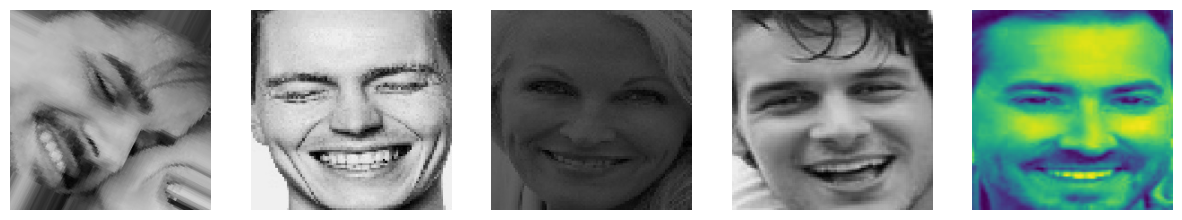

In [56]:
sample_images(train_dir, "happy")

### **DATA TRANSFORMATION**

We'll preprocess the images using transforms.compose pipeline. The steps include;


1. The images to be converted to RGB format.
2. Resize images to height and width of 224, 224.
3. Convert the images to pytorch tensors.

In [10]:
class ConvertToRGB:
  def __call__(self, img):
    if img != "RGB":
      img = img.convert("RGB")
    return img

In [11]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

**NORMALIZE**

Normalization scales the mean and std of the color channels to a standard value.

In [46]:
def fetch_mean_std(loader):
  """Calculates the mean and std of each color channel"""
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1

  mean = channels_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2)**0.5
  return mean, std

In [47]:
train_mean, train_std = fetch_mean_std(train_loader)
print(train_mean, train_std)

Computing mean and std:   0%|          | 0/213 [00:00<?, ?it/s]

tensor([-0.0005, -0.0005, -0.0005]) tensor([0.9998, 0.9998, 0.9998])


In [14]:
val_mean, val_std = fetch_mean_std(val_loader)
print(val_mean, val_std)

  0%|          | 0/72 [00:00<?, ?it/s]

tensor([0.4430, 0.4430, 0.4430]) tensor([0.2392, 0.2392, 0.2392])


**TRANSFORMS WITH NORMALIZATION**

In [17]:
train_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])
val_transorm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(val_mean, val_std)
])

**IMAGE FOLDER**

In [18]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 6799
    Root location: /content/dataset/Emotions Dataset/Emotions Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4374, 0.4374, 0.4374]), std=tensor([0.2362, 0.2362, 0.2362]))
           )


In [20]:
val_dataset = datasets.ImageFolder(val_dir, transform=val_transorm)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 2278
    Root location: /content/dataset/Emotions Dataset/Emotions Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4430, 0.4430, 0.4430]), std=tensor([0.2392, 0.2392, 0.2392]))
           )


In [23]:
fetch_mean_std(train_loader)

  0%|          | 0/213 [00:00<?, ?it/s]

(tensor([-0.0003, -0.0003, -0.0003]), tensor([0.9999, 0.9999, 0.9999]))

**DATA LOADER**

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [24]:
next_batch = next(iter(train_loader))
print(next_batch[0].shape)

torch.Size([32, 3, 224, 224])


In [25]:
next_batch = next(iter(val_loader))
print(next_batch[0].shape)

torch.Size([32, 3, 224, 224])


**CLASS BALANCE**

In [26]:
def class_counts(dataset):
  # Get class labels
  c = Counter(x[1] for x in tqdm(dataset))
  # Access the mapping from class names
  class_to_index = dataset.class_to_idx

  return pd.Series({cat: c[i] for cat, i in class_to_index.items()})

**TRAIN DISTRIBUTION**

  0%|          | 0/6799 [00:00<?, ?it/s]

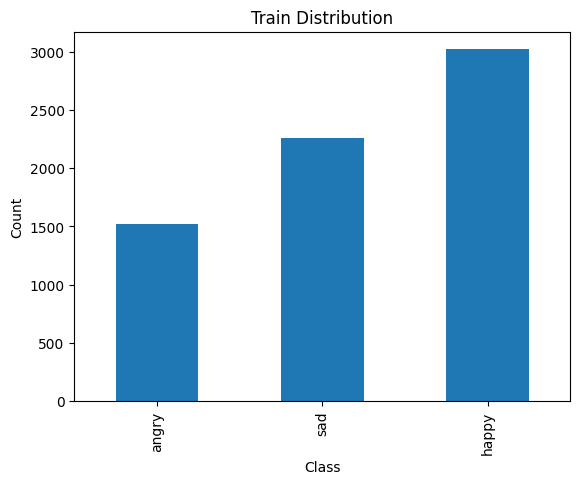

In [27]:
train_distribution = class_counts(train_dataset)
train_distribution.sort_values().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Train Distribution")
plt.show();

**VAL DISTRIBUTION**

  0%|          | 0/2278 [00:00<?, ?it/s]

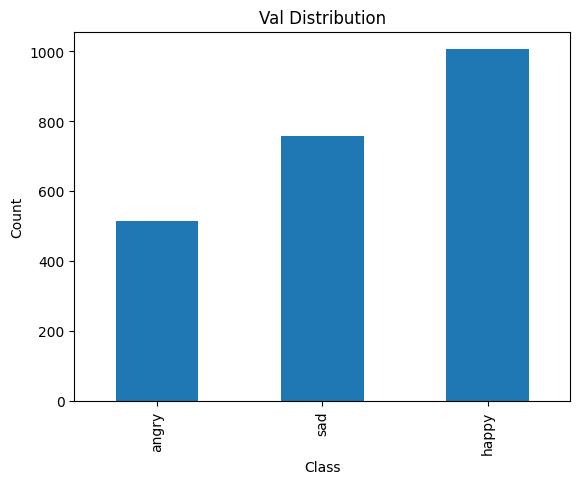

In [28]:
val_distribution = class_counts(val_dataset)
val_distribution.sort_values().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Val Distribution")
plt.show();

## **IMPLEMENTING TRANSFER LEARNING**

**RESNET 50 DEFINITION**

In [29]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


In [30]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

**TURN OFF BACK PROPAGATION**

In [31]:
for params in model.parameters():
  params.requires_grad = False

In [32]:
# Move the model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**MODIFY THE NETWORK**

**INPUT FEATURES EXTRACTION**

In [35]:
list(model.named_modules())[-1]
in_features = model.fc.in_features
print(in_features)

2048


**LINEAR LAYER**

In [37]:
classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)
)

In [40]:
# Replace the output layer in resnet with classifier
model.fc = classifier

In [41]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

**TRAINING**

In [42]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
def train(model, optimizer, loss_fn, data_loader, device="cpu"):

  # Initialize training loss
  training_loss = 0.0

  # Set the model in training mode, no training has happenedd
  model.train()

  # Iterate over all batches
  for inputs, labels in tqdm(data_loader):
    # Reset the gradients of all model parameters
    optimizer.zero_grad()
    # Move inputs, labels to device, unpack
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Forward propagation, obtain loss
    output = model(inputs)
    loss = loss_fn(output, labels)
    # Backpropagation
    loss.backward()
    # Update parameters
    optimizer.step()
    # Increment the training loss for the current batch
    training_loss += loss.data.items() * inputs.size(0)

    return training_loss / len(data_loader.dataset)